## PD - Probability of Default

This notebook aims to come up with a general methodology for selecting features for PD model - as well as for finding the best categories for the features.

In [99]:
from datetime import datetime
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

from credit_risk_modeling.cleaning import DatetimeConverter, NumericExtractor
from credit_risk_modeling.feature_engineering import TimeSinceCalculator, OHECategoriesCreator
from credit_risk_modeling.eda import compute_woe, plot_woe_by_category

#### Get data and select columns

In [100]:
selected_cols = [
    "id", "member_id", "loan_amnt", "funded_amnt", "term", "int_rate", "installment", "grade", "emp_length", 
    "home_ownership", "annual_inc", "issue_d", "loan_status", "purpose", "addr_state", "dti", "delinq_2yrs", 
    "earliest_cr_line", "verification_status", "initial_list_status", "inq_last_6mths", "open_acc", "pub_rec", 
    "total_acc", "acc_now_delinq", "total_rev_hi_lim"
]

In [101]:
df = pd.read_csv("../data/loan_data.csv")
df = df.loc[:, selected_cols]

/Users/gfluz94/.credit-risk/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3442: DtypeWarning: Columns (20) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


#### Clean, Preprocess and Create Features

In [102]:
datetime_cols = ["earliest_cr_line", "issue_d"]
datetime_format = "%b-%y"
time_unit = "month"
reference_date = datetime(2017, 12, 1)

datetime_converter = DatetimeConverter(
    field_names=datetime_cols,
    datetime_format=datetime_format
)
df = datetime_converter.transform(df)

for datetime_col in datetime_cols:
    time_since_calculator = TimeSinceCalculator(
        field_name=datetime_col, reference_date=reference_date, time_unit=time_unit, winsorize_max=True,
    )
    df = time_since_calculator.transform(df)

In order for us to continue with the analysis, we just need to carry out two additional steps:

* Define target variable

In [103]:
DEFAULT_CATEGORIES = [
    "Charged Off",
    "Late (31-120 days)",
    "Default",
    "Does not meet the credit policy. Status:Charged Off"
]
TARGET_VARIABLE = "default"

df[TARGET_VARIABLE] = df["loan_status"].isin(DEFAULT_CATEGORIES).astype(float)
(df[TARGET_VARIABLE].value_counts() / len(df)).apply(lambda x: f"{100*x:.2f}%")

0.0    89.07%
1.0    10.93%
Name: default, dtype: object

* Split our dataset into training and test, so that we avoid data leakage at all costs.

In [104]:
df_train, df_test = train_test_split(df, test_size=0.20, random_state=99, stratify=df[TARGET_VARIABLE])

#### Categorical Features

It is time for us now to take a closer look at categorical variables and, according to WoE analysis, select the best categories for each feature.

We are going to analyze the following variables:

* `grade`
* `home_ownership`
* `addr_state`
* `verification_status`
* `purpose`
* `initial_list_status`

In [105]:
transformers = []
features = []
reference_categories = []

1. `grade`

In [106]:
variable = "grade"

In [107]:
print(f"{100*df_train[variable].isnull().mean():.2f}% missing!\n\n")
print(df_train[variable].value_counts())

0.00% missing!


B    109603
C    100372
D     61548
A     59796
E     28514
F     10502
G      2693
Name: grade, dtype: int64


In [108]:
woe_df = compute_woe(
    df=df_train,
    id_column_name="id",
    feature_column_name=variable,
    target_column_name=TARGET_VARIABLE,
)
woe_df

,Non-Default,Default,Total Obs,% Non-Default,% Default,WoE,IV
grade,,,,,,,
A,57506,2290,59796,0.173078,0.056163,-1.125482,0.29095
B,100983,8620,109603,0.303933,0.211409,-0.363012,0.29095
C,88788,11584,100372,0.267229,0.284103,0.061228,0.29095
D,52076,9472,61548,0.156736,0.232305,0.393491,0.29095
E,22981,5533,28514,0.069167,0.135699,0.673917,0.29095
F,7960,2542,10502,0.023958,0.062344,0.956377,0.29095
G,1960,733,2693,0.005899,0.017977,1.114301,0.29095


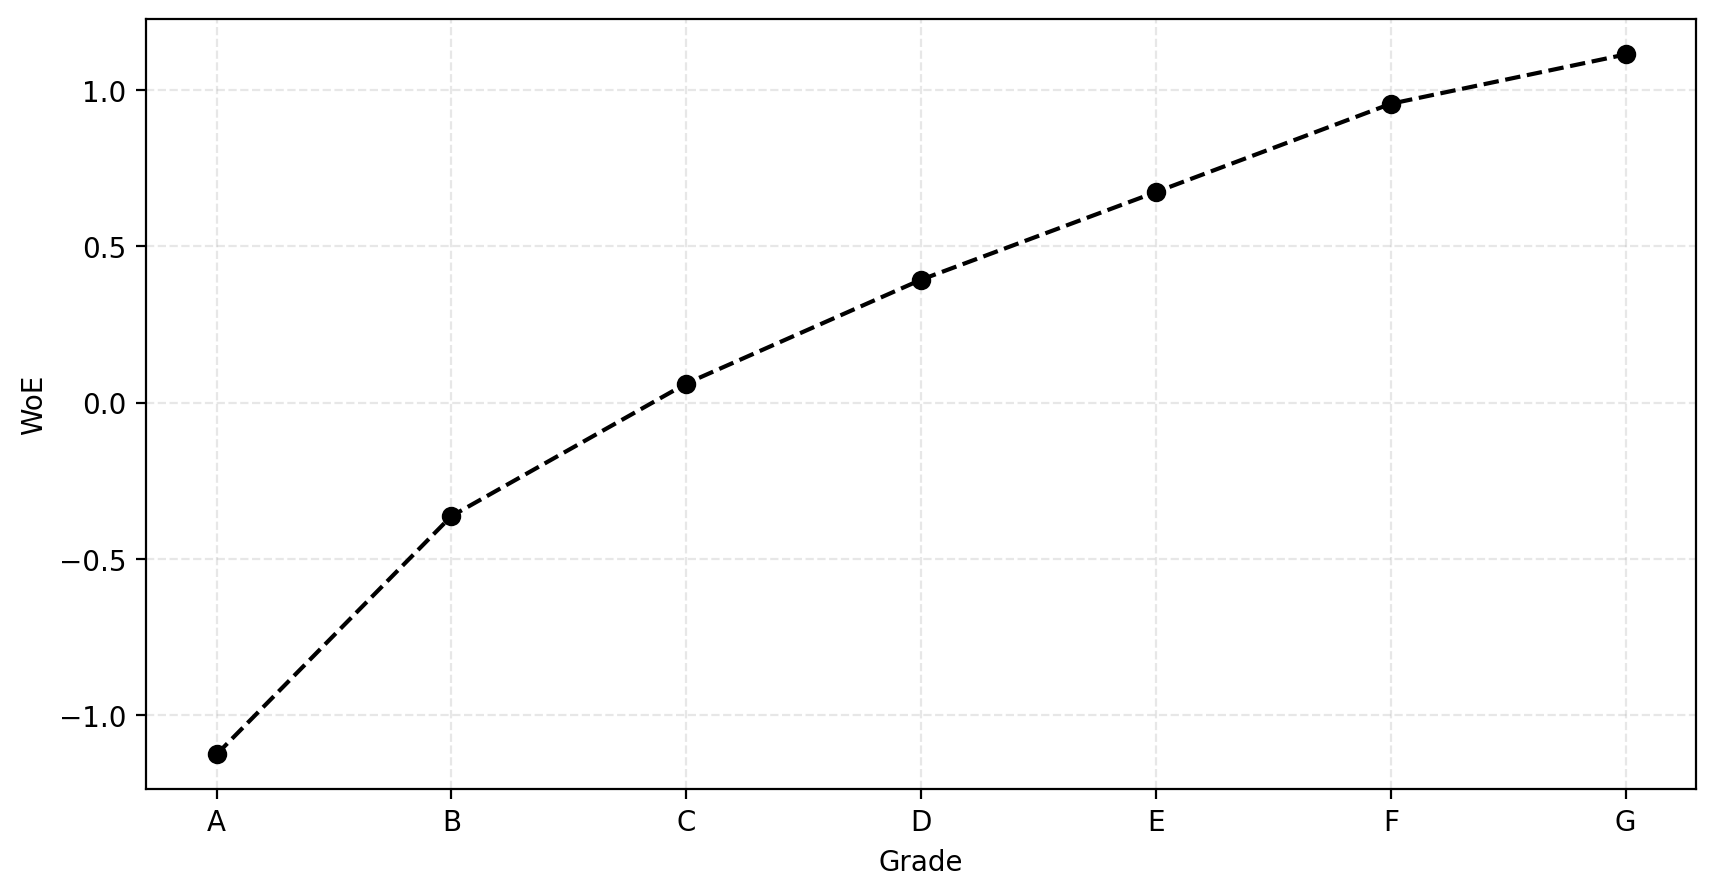

In [109]:
plot_woe_by_category(woe_df)

Based on the analysis above, we are going to keep the current seven categories (A -> G). We can notice that the curve almost increases monotonically, from A to G, meaning that A is the best score and G is the worst one.

In [110]:
final_categories = {
    "A": ["A"],
    "B": ["B"],
    "C": ["C"],
    "D": ["D"],
    "E": ["E"],
    "F": ["F"],
    "G": ["G"],
}

grade_ohe = OHECategoriesCreator(field_name=variable, final_categories_dict=final_categories)
df_train = grade_ohe.fit_transform(df_train)
transformers.append(grade_ohe)

In [111]:
features += [f"{variable}_{cat}" for cat in final_categories.keys()]
reference_categories.append(f"{variable}_" + "G")

2. `home_ownership`

In [112]:
variable = "home_ownership"

In [113]:
print(f"{100*df_train[variable].isnull().mean():.2f}% missing!\n\n")
print(df_train[variable].value_counts())

0.00% missing!


MORTGAGE    188830
RENT        150642
OWN          33364
OTHER          152
NONE            39
ANY              1
Name: home_ownership, dtype: int64


In [114]:
woe_df = compute_woe(
    df=df_train,
    id_column_name="id",
    feature_column_name=variable,
    target_column_name=TARGET_VARIABLE,
)
woe_df

,Non-Default,Default,Total Obs,% Non-Default,% Default,WoE,IV
home_ownership,,,,,,,
MORTGAGE,170688.0,18142.0,188830.0,0.513727,0.444940,-0.143753,0.021492
OWN,29755.0,3609.0,33364.0,0.089555,0.088512,-0.011711,0.021492
RENT,131658.0,18984.0,150642.0,0.396257,0.465591,0.161244,0.021492
NONE,34.0,5.0,39.0,0.000102,0.000123,0.180933,0.021492
OTHER,118.0,34.0,152.0,0.000355,0.000834,0.853531,0.021492
ANY,1.0,NaN,1.0,0.000003,NaN,NaN,0.021492


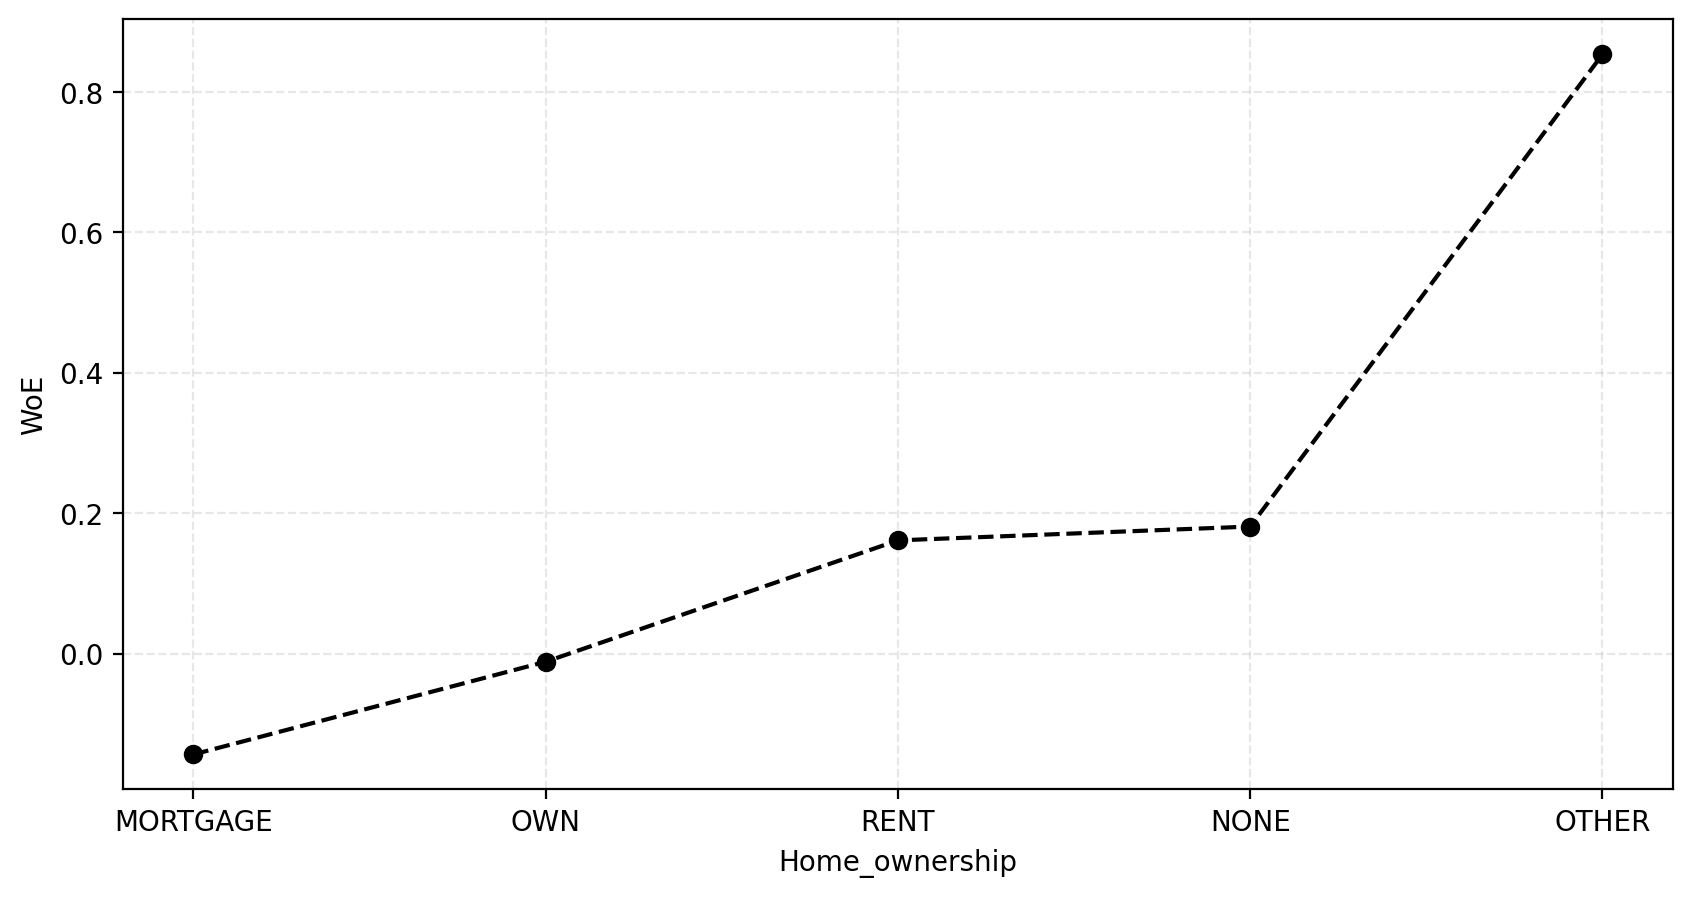

In [115]:
plot_woe_by_category(woe_df)

From the WoE resultsa above, we can notice that `NONE`, `OTHER` and `ANY` are not representative, due to small number of observations. Also, their meaning is not clear, hence from a **conservative risk-management attitude**, we should assume the worst or highest-risk - in this case, `RENT`.

In [116]:
df_train_ = df_train.copy()
df_train_[variable] = np.where(
    df_train_[variable].isin(["NONE", "OTHER", "RENT", "ANY"]),
    "NONE_OTHER_RENT_ANY",
    df_train_[variable]
)
woe_df = compute_woe(
    df=df_train_,
    id_column_name="id",
    feature_column_name=variable,
    target_column_name=TARGET_VARIABLE,
)
woe_df

,Non-Default,Default,Total Obs,% Non-Default,% Default,WoE,IV
home_ownership,,,,,,,
MORTGAGE,170688,18142,188830,0.513727,0.444940,-0.143753,0.021222
OWN,29755,3609,33364,0.089555,0.088512,-0.011711,0.021222
NONE_OTHER_RENT_ANY,131811,19023,150834,0.396718,0.466547,0.162135,0.021222


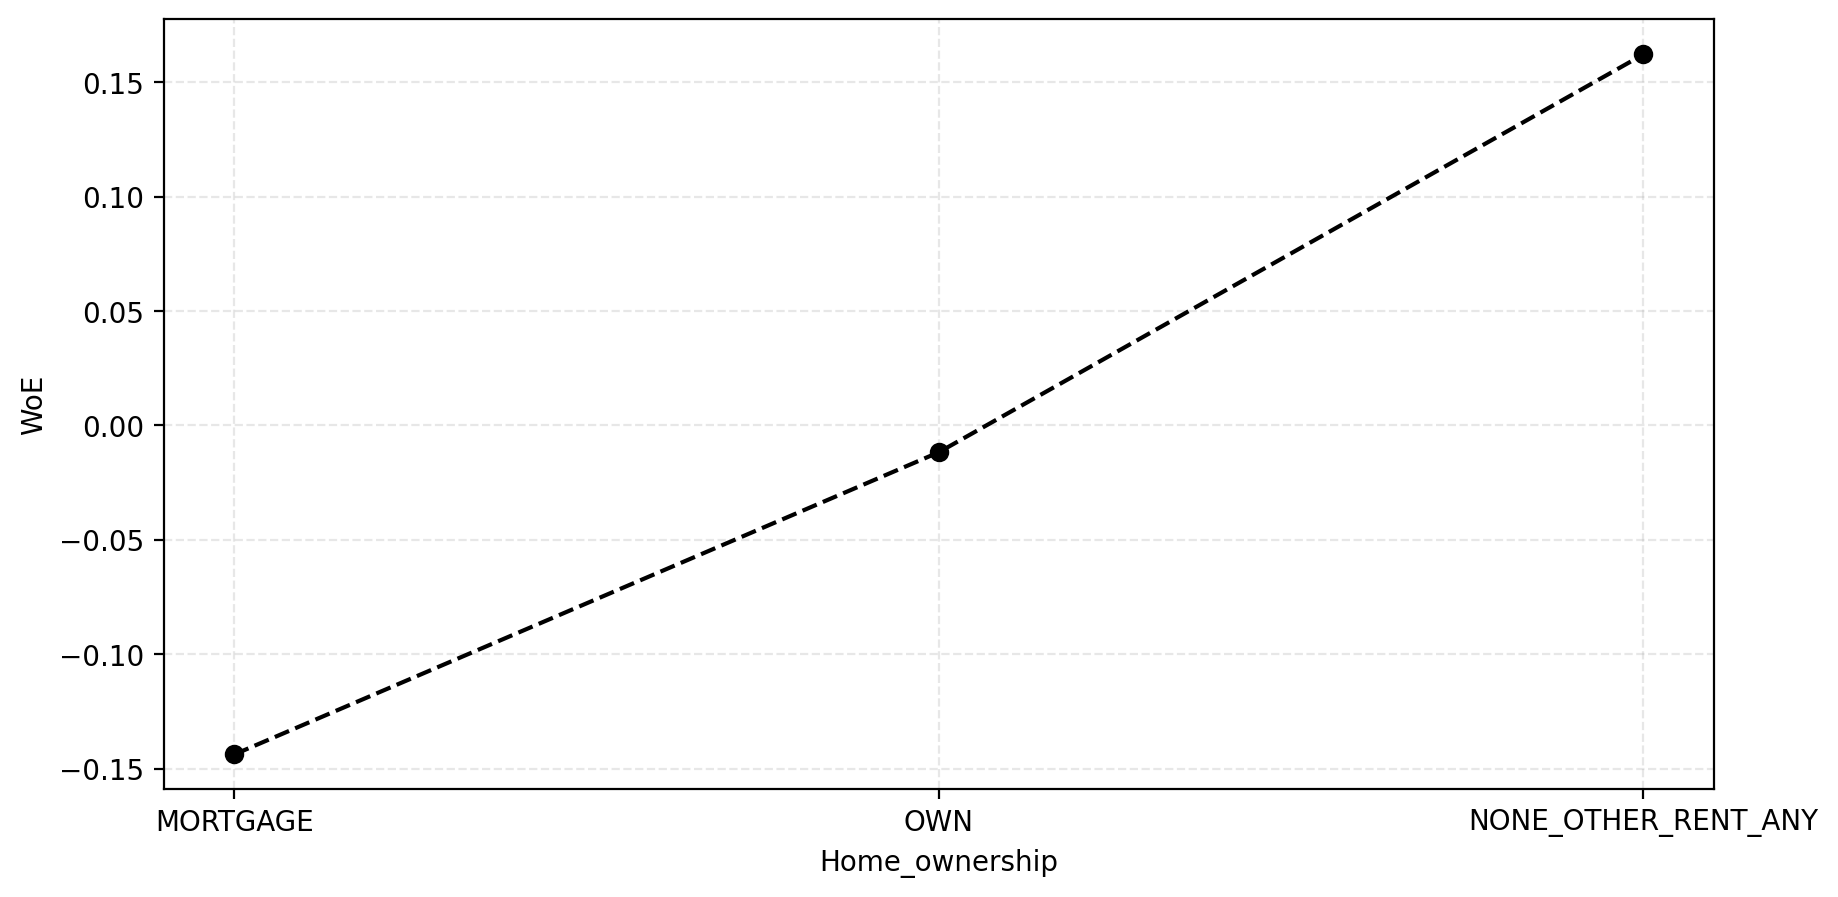

In [117]:
plot_woe_by_category(woe_df)

In [118]:
final_categories = {
    "NONE_OTHER_RENT_ANY": ["NONE", "OTHER", "RENT", "ANY"],
    "MORTGAGE": ["MORTGAGE"],
    "OWN": ["OWN"],
}

grade_ohe = OHECategoriesCreator(field_name=variable, final_categories_dict=final_categories)
df_train = grade_ohe.fit_transform(df_train)
transformers.append(grade_ohe)

In [119]:
features += [f"{variable}_{cat}" for cat in final_categories.keys()]
reference_categories.append(f"{variable}_" + "NONE_OTHER_RENT_ANY")

3. `addr_state`

In [120]:
variable = "addr_state"

In [121]:
print(f"{100*df_train[variable].isnull().mean():.2f}% missing!\n\n")
print(df_train[variable].unique())
print(df_train[variable].nunique())

0.00% missing!


['CA' 'TX' 'IL' 'NY' 'PA' 'FL' 'MD' 'KS' 'AL' 'WA' 'AZ' 'NC' 'SC' 'GA'
 'IN' 'NJ' 'OR' 'MI' 'NV' 'OK' 'VA' 'WY' 'CT' 'NM' 'OH' 'MO' 'TN' 'CO'
 'MA' 'WV' 'NH' 'LA' 'DE' 'KY' 'UT' 'VT' 'AR' 'WI' 'HI' 'MN' 'DC' 'MT'
 'RI' 'SD' 'MS' 'AK' 'NE' 'ID' 'ME' 'IA']
50


From the list above, since we would expect 50 states + 1 DC, we realize that `ND` is missing. Let's add it then to the `highest-risk-category`.

In [122]:
woe_df = compute_woe(
    df=df_train,
    id_column_name="id",
    feature_column_name=variable,
    target_column_name=TARGET_VARIABLE,
)
woe_df

,Non-Default,Default,Total Obs,% Non-Default,% Default,WoE,IV
addr_state,,,,,,,
DC,1074.0,78.0,1152.0,0.003232,0.001913,-0.524581,0.013262
WY,831.0,67.0,898.0,0.002501,0.001643,-0.420082,0.013262
NH,1632.0,145.0,1777.0,0.004912,0.003556,-0.322973,0.013262
MS,907.0,82.0,989.0,0.002730,0.002011,-0.305568,0.013262
AK,915.0,83.0,998.0,0.002754,0.002036,-0.302228,0.013262
MT,1032.0,94.0,1126.0,0.003106,0.002305,-0.298104,0.013262
VT,667.0,61.0,728.0,0.002008,0.001496,-0.294061,0.013262
WV,1738.0,168.0,1906.0,0.005231,0.004120,-0.238671,0.013262
KS,3045.0,296.0,3341.0,0.009165,0.007260,-0.233042,0.013262


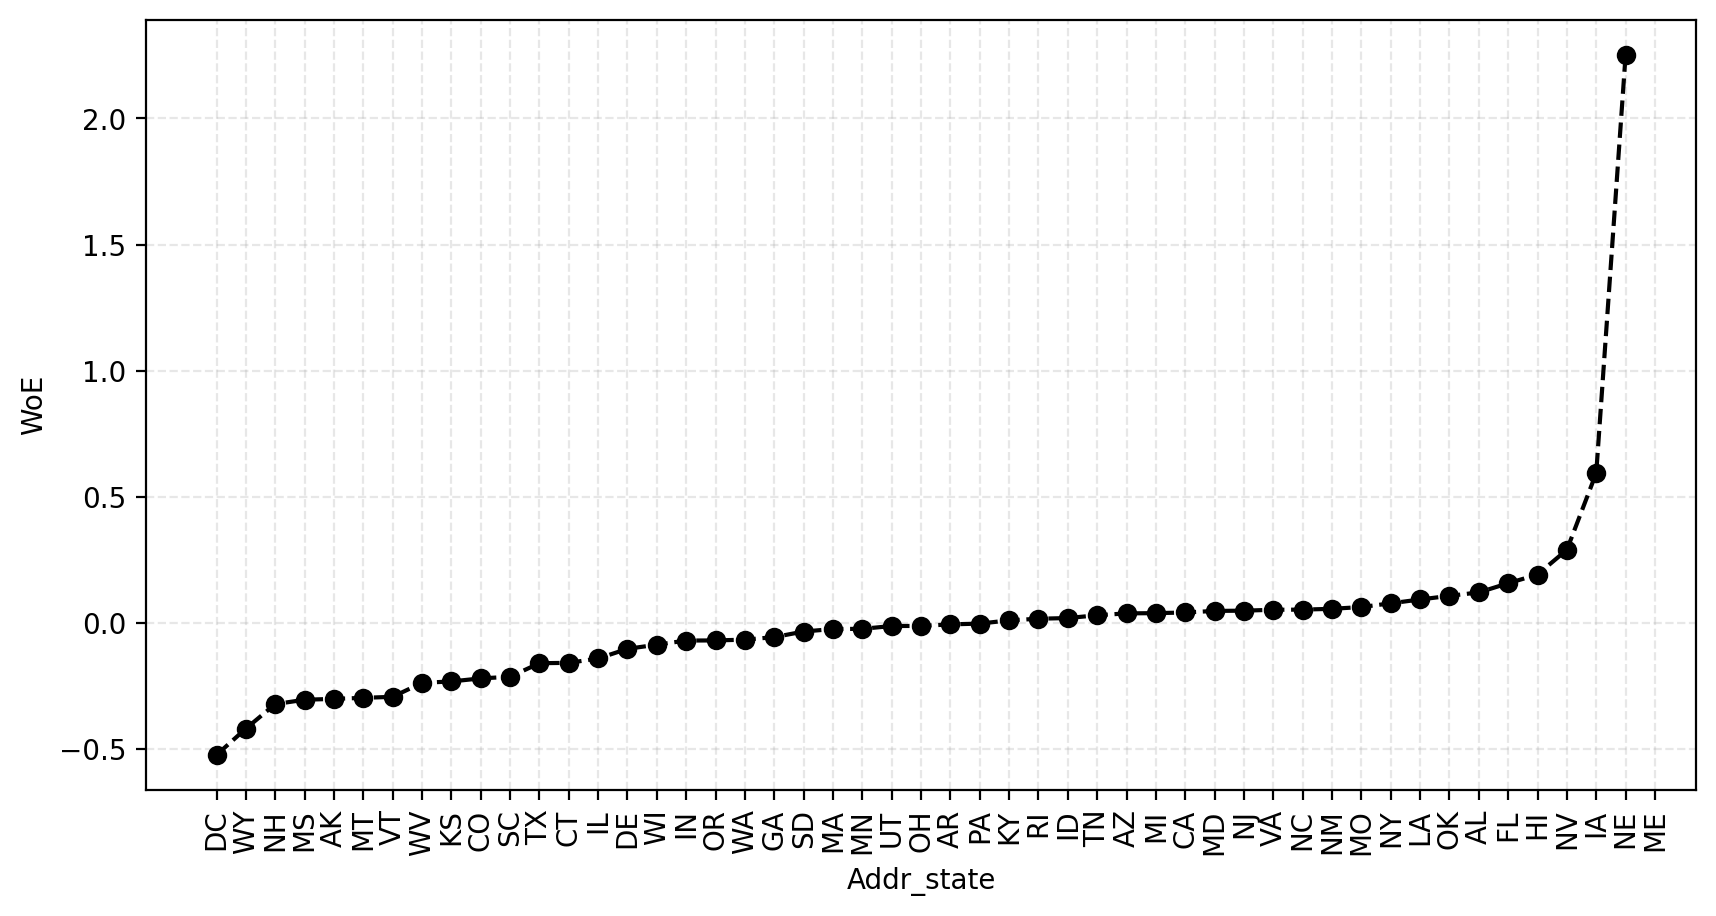

In [123]:
plot_woe_by_category(woe_df, rotate=True)

This visualization could be misleading due to the scale... Last 3 categories (`ME`, `NE` and `IA`) are not representative, hence let's keep them out for a while.

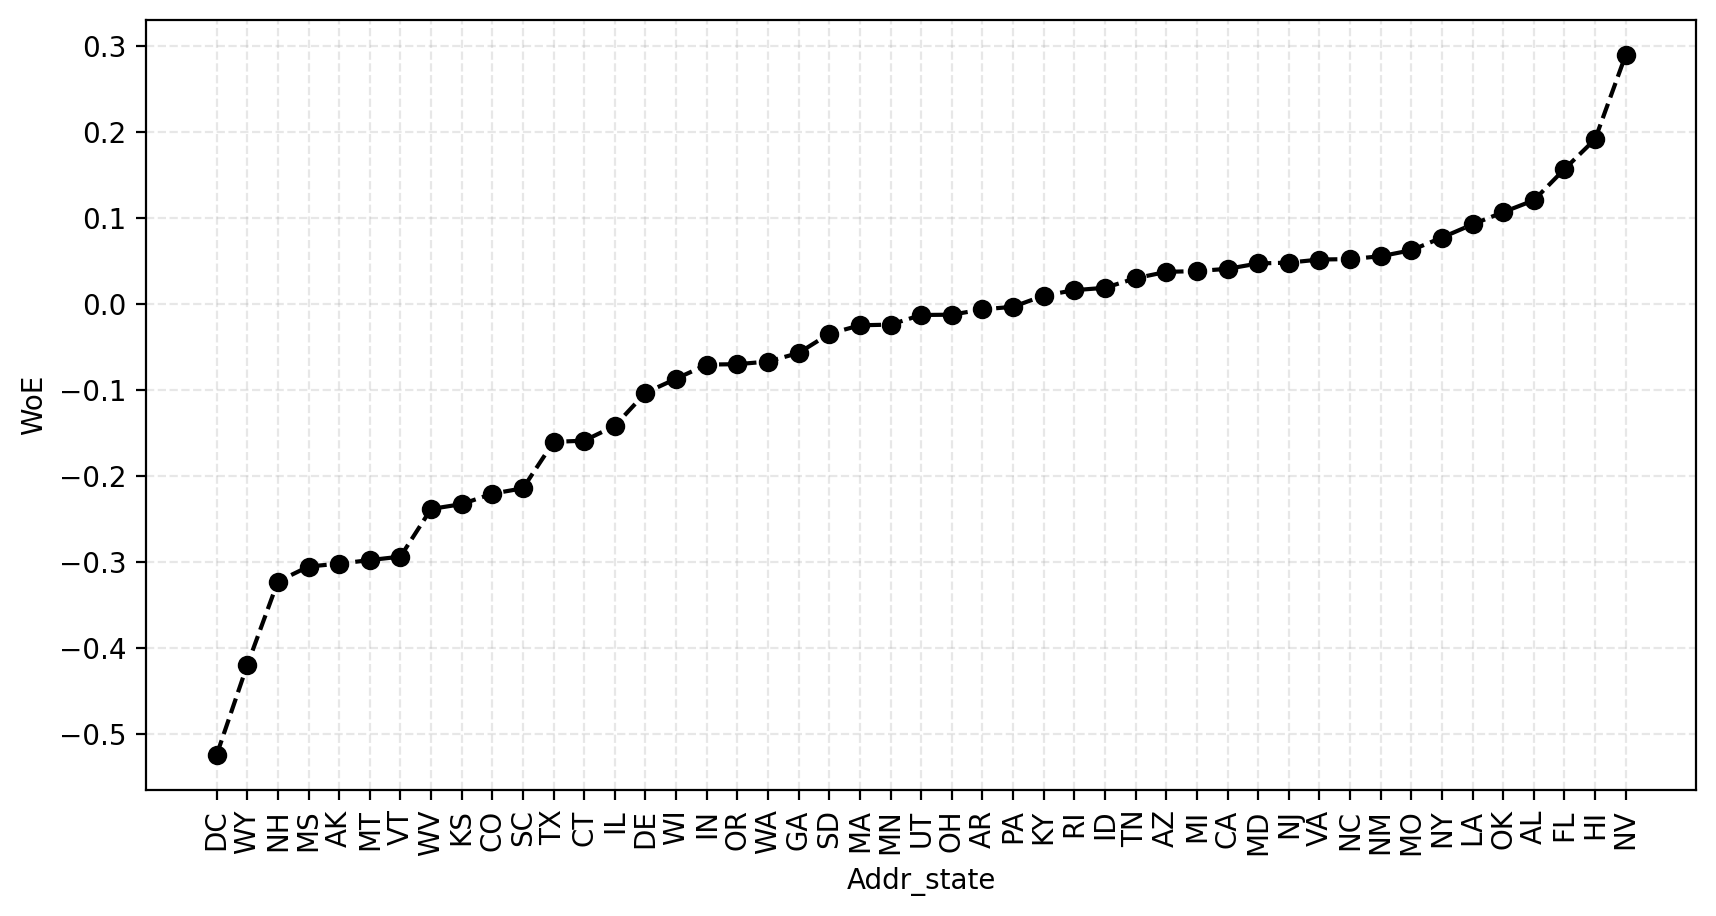

In [124]:
plot_woe_by_category(woe_df.iloc[:-3, :], rotate=True)

In a descending order:

* `NV` stands out from `HI` and is representative, so it should be a separate category that includes the missing state (`ND`) and the 3 non-representative ones above it (`ME`, `NE` and `IA`)

* `HI` has a higher WoE than `FL`, which stands out a lot (22k). So both should be kept as categories of their own

* `AL`, `OK` and `LA` should be groupped together

* Even though `NY` has similar WoE to its neighbours in the table, it stands out, so let's keep it apart

* `MO` should be kept as a different category

* `MD`, `NJ`, `VA`, `NC`, `NM` and `MD` should be groupped together

* Even though `CA` has similar WoE to its neighbours in the table, it stands out, so let's keep it apart

* `TN`, `AZ` and `MI` should be groupped together

* `KY`, `RI` and `ID` should be groupped together

* `PA`, `AR`, `OH` and `UT` should be groupped together

* `MN`, `MA` and `SD` should be groupped together

* `IN`, `OR`, `WA` and `GA` should be groupped together

* `WI` and `DE` should be groupped together (due to the fact that DE is not representative)

* `IL`, `TX` and `CT` should be kept as separate categories. `TX` and `CT` have similar WoE, but `TX` really stands out

* `WV`, `KS`, `CO` and `SC` should be groupped together

* `MS`, `AK`, `MT` and `VT` should be groupped together

* `NH`, `WY` and `DC` have different WoE, however they are not representative. Since they are on the edge of the spectrum, we group them together

In [125]:
final_categories = {
    "NV_ND_ME_NE_IA": ["NV", "ND", "ME", "NE", "IA"],
    "HI": ["HI"],
    "FL": ["FL"],
    "AL_OK_LA": ["AL", "OK", "LA"],
    "NY": ["NY"],
    "MO": ["MO"],
    "MD_NJ_VA_NC_NM": ["NJ", "VA", "NC", "NM", "MD"],
    "CA": ["CA"],
    "TN_AZ_MI": ["TN", "AZ", "MI"],
    "KY_RI_ID": ["KY", "RI", "ID"],
    "PA_AR_OH_UT": ["PA", "AR", "OH", "UT"],
    "MN_MA_SD": ["MN", "MA", "SD"],
    "IN_OR_WA_GA": ["IN", "OR", "WA", "GA"],
    "WI_DE": ["WI", "DE"],
    "IL": ["IL"],
    "TX": ["TX"],
    "CT": ["CT"],
    "WV_KS_CO_SC": ["WV", "KS", "CO", "SC"],
    "MS_AK_MT_VT": ["MS", "AK", "MT", "VT"],
    "NH_WY_DC": ["NH", "WY", "DC"],   
}

grade_ohe = OHECategoriesCreator(field_name=variable, final_categories_dict=final_categories)
df_train = grade_ohe.fit_transform(df_train)
transformers.append(grade_ohe)

In [131]:
df_train[filter(lambda x: x.startswith(variable), df_train.columns)].sum(axis=1).sum() == len(df_train)

True

In [127]:
features += [f"{variable}_{cat}" for cat in final_categories.keys()]
reference_categories.append(f"{variable}_" + "NV_ND_ME_NE_IA")

4. `verification_status`

In [132]:
variable = "verification_status"

In [133]:
print(f"{100*df_train[variable].isnull().mean():.2f}% missing!\n\n")
print(df_train[variable].value_counts())

0.00% missing!


Verified           134457
Source Verified    119799
Not Verified       118772
Name: verification_status, dtype: int64


In [134]:
woe_df = compute_woe(
    df=df_train,
    id_column_name="id",
    feature_column_name=variable,
    target_column_name=TARGET_VARIABLE,
)
woe_df

,Non-Default,Default,Total Obs,% Non-Default,% Default,WoE,IV
verification_status,,,,,,,
Not Verified,107487,11285,118772,0.323509,0.276770,-0.156040,0.018866
Source Verified,107329,12470,119799,0.323033,0.305832,-0.054718,0.018866
Verified,117438,17019,134457,0.353458,0.417398,0.166275,0.018866


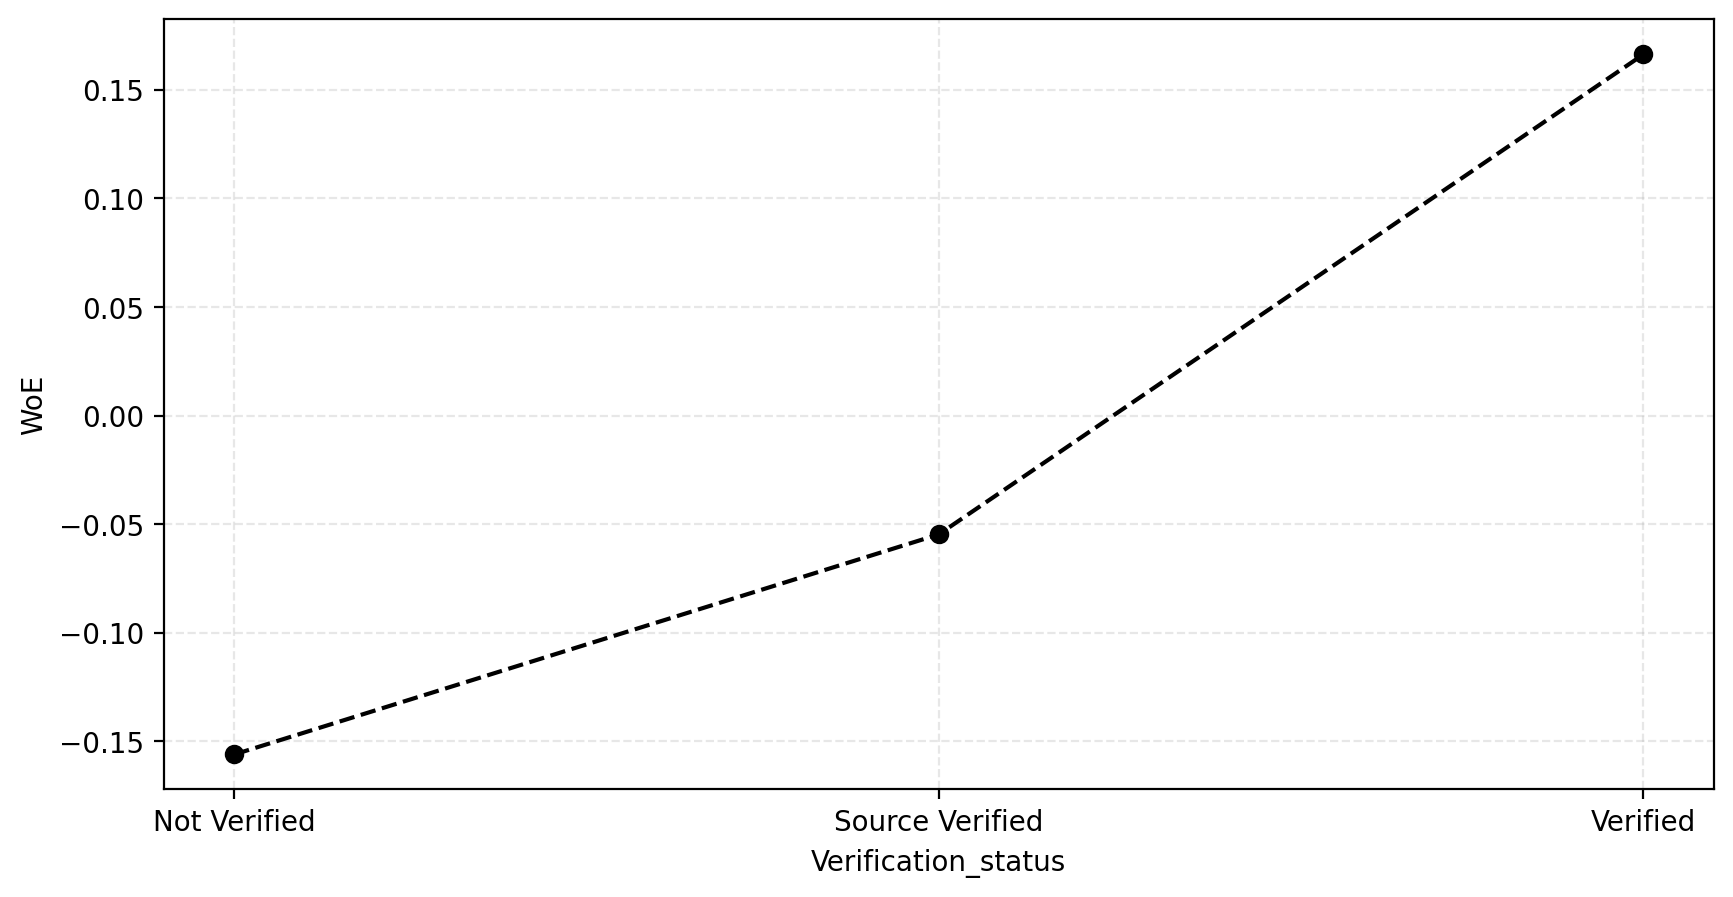

In [135]:
plot_woe_by_category(woe_df)

From the WoE resultsa above, we can notice that WoE almost increases monotonically. Hence, we are good to go.

In [136]:
final_categories = {
    v: [v] for v in df_train[variable].unique()
}

grade_ohe = OHECategoriesCreator(field_name=variable, final_categories_dict=final_categories)
df_train = grade_ohe.fit_transform(df_train)
transformers.append(grade_ohe)

In [137]:
features += [f"{variable}_{cat}" for cat in final_categories.keys()]
reference_categories.append(f"{variable}_" + "Verified")

5. `purpose`

In [139]:
variable = "purpose"

In [140]:
print(f"{100*df_train[variable].isnull().mean():.2f}% missing!\n\n")
print(df_train[variable].value_counts())

0.00% missing!


debt_consolidation    219434
credit_card            83206
home_improvement       21215
other                  19049
major_purchase          7893
small_business          5619
car                     4316
medical                 3658
moving                  2359
vacation                1949
wedding                 1890
house                   1831
educational              323
renewable_energy         286
Name: purpose, dtype: int64


In [141]:
woe_df = compute_woe(
    df=df_train,
    id_column_name="id",
    feature_column_name=variable,
    target_column_name=TARGET_VARIABLE,
)
woe_df

,Non-Default,Default,Total Obs,% Non-Default,% Default,WoE,IV
purpose,,,,,,,
car,3951,365,4316,0.011892,0.008952,-0.283972,0.036922
credit_card,76044,7162,83206,0.228873,0.175651,-0.264668,0.036922
major_purchase,7129,764,7893,0.021456,0.018737,-0.135503,0.036922
home_improvement,19126,2089,21215,0.057564,0.051234,-0.116508,0.036922
debt_consolidation,194540,24894,219434,0.585516,0.610536,0.041844,0.036922
vacation,1720,229,1949,0.005177,0.005616,0.081498,0.036922
wedding,1657,233,1890,0.004987,0.005714,0.136130,0.036922
medical,3168,490,3658,0.009535,0.012017,0.231405,0.036922
other,16442,2607,19049,0.049486,0.063938,0.256216,0.036922


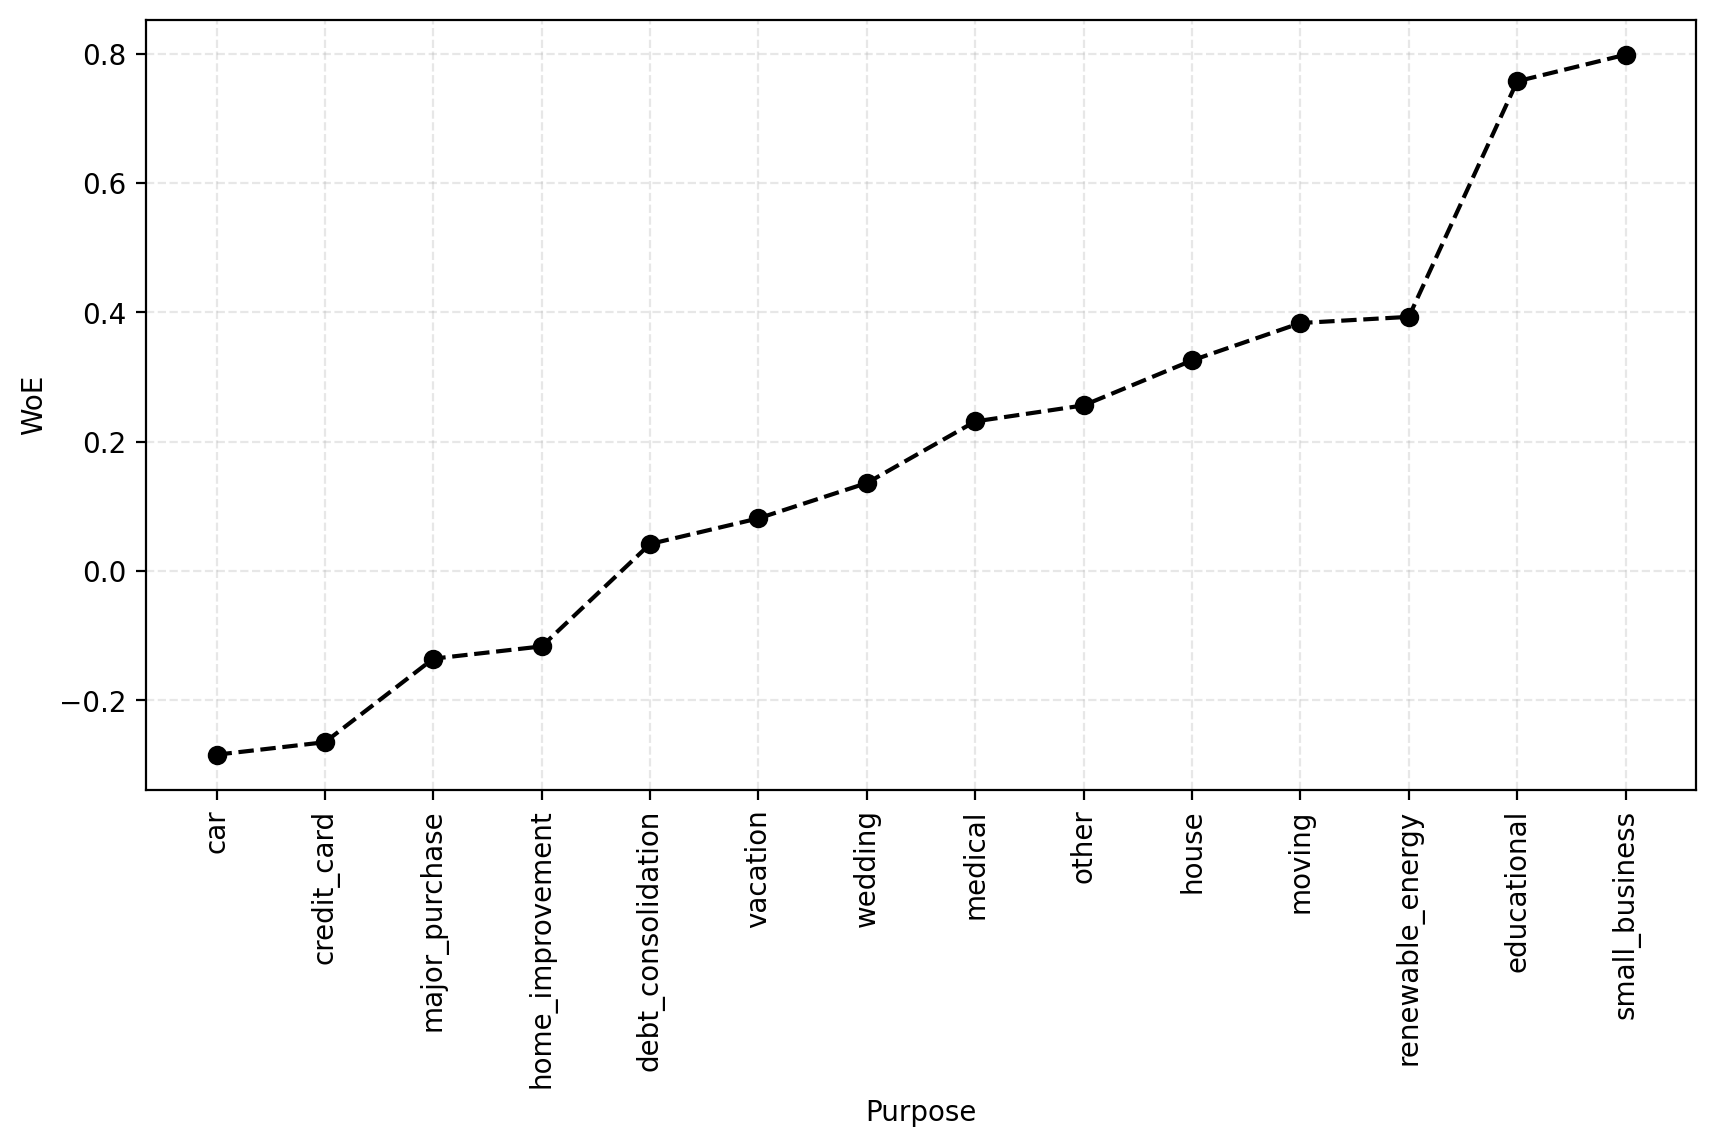

In [143]:
plot_woe_by_category(woe_df, rotate=True)

From the results above, the only categories that should be groupped together are:

* `educational` and `small_business`

* `house`, `moving` and `renewable_energy`

* `vacation` and `wedding`

* `major_purchase` and `home_improvement`

In [145]:
final_categories = {
    "car": ["car"],
    "credit_card": ["credit_card"],
    "major_purchase_home_improvement": ["major_purchase", "home_improvement"],
    "debt_consolidation": ["debt_consolidation"],
    "vacation_wedding": ["vacation", "wedding"],
    "medical": ['medical'],
    "other": ["other"],
    "renewable_energy_house_moving": ["renewable_energy", "house", "moving"],
    "educational_small_business": ["small_business", "educational"],
}

grade_ohe = OHECategoriesCreator(field_name=variable, final_categories_dict=final_categories)
df_train = grade_ohe.fit_transform(df_train)
transformers.append(grade_ohe)

In [146]:
df_train[filter(lambda x: x.startswith(variable), df_train.columns)].sum(axis=1).sum() == len(df_train)

True

In [150]:
features += [f"{variable}_{cat}" for cat in final_categories.keys()]
reference_categories.append(f"{variable}_" + "educational_small_business")

6. `initial_list_status`

In [154]:
variable = "initial_list_status"

In [155]:
print(f"{100*df_train[variable].isnull().mean():.2f}% missing!\n\n")
print(df_train[variable].value_counts())

0.00% missing!


f    242532
w    130496
Name: initial_list_status, dtype: int64


In [156]:
woe_df = compute_woe(
    df=df_train,
    id_column_name="id",
    feature_column_name=variable,
    target_column_name=TARGET_VARIABLE,
)
woe_df

,Non-Default,Default,Total Obs,% Non-Default,% Default,WoE,IV
initial_list_status,,,,,,,
w,118893,11603,130496,0.357838,0.284569,-0.229105,0.024703
f,213361,29171,242532,0.642162,0.715431,0.108045,0.024703


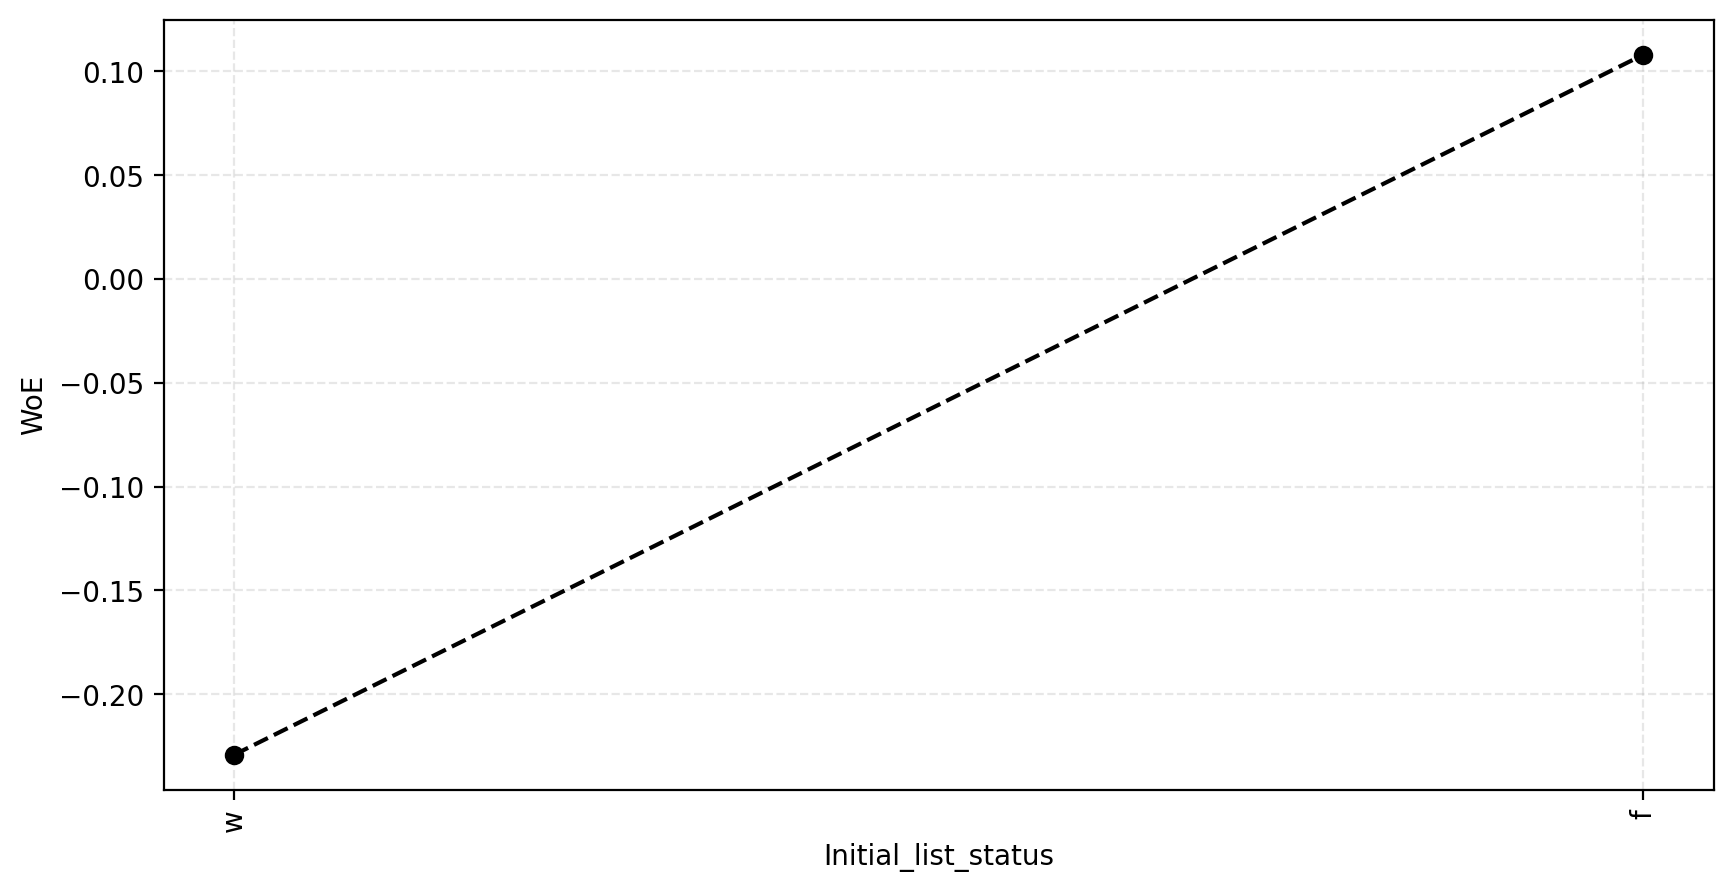

In [157]:
plot_woe_by_category(woe_df, rotate=True)

Since there are two categories, and only 2, we are good to go.

In [158]:
final_categories = {
    v: [v] for v in df_train[variable].unique()
}

grade_ohe = OHECategoriesCreator(field_name=variable, final_categories_dict=final_categories)
df_train = grade_ohe.fit_transform(df_train)
transformers.append(grade_ohe)

In [159]:
df_train[filter(lambda x: x.startswith(variable), df_train.columns)].sum(axis=1).sum() == len(df_train)

True

In [160]:
features += [f"{variable}_{cat}" for cat in final_categories.keys()]
reference_categories.append(f"{variable}_" + "f")